In [6]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, precision_score
import matplotlib.pyplot as plt
from ggplot import *
import itertools
%matplotlib inline

In [2]:
# FUNCTION plot_confusion_matrix: This function prints and plots the confusion
# matrix. Normalization can be applied by setting `normalize=True`. Version from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# FUNCTION basic_metrics: to calculate and print basic metrics for each model
def basic_metrics(preds, y_test_labels):
  metrics.accuracy_score(preds, y_test_labels)
  accu_dtc = accuracy_score(y_test_labels, preds, normalize=True)
  prec_dtc_all = precision_score(y_test_labels, preds, pos_label="ALL")
  prec_dtc_aml = precision_score(y_test_labels, preds, pos_label="AML")
  print("Accuracy:%.2f" %accu_dtc)
  print("Precision ALL: %.2f" %prec_dtc_all)
  print("Precision AML: %.2f \n" %prec_dtc_aml)
  cfmatrix = confusion_matrix(y_true=y_test_labels, y_pred=preds)
  class_names = ['ALL', 'AML']
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cfmatrix, classes=class_names,
                        title='Confusion matrix')

In [3]:
################################################################################
#***DATA READER*** Takes 3 CSV files and cleans data so that the data items are
# in the form of learning examples(a two dimensional array of samples, each row
# corresponds to a sample (patient) and each column corresponds to a feature
# (gene expression).
testfile='data_set_ALL_AML_independent.csv'
trainfile='data_set_ALL_AML_train.csv'
ct_target='actual.csv'

#import data sets (train and test samples with gene expression values + cancer type labels)
raw_train = pd.read_csv(trainfile)
raw_test = pd.read_csv(testfile)
ct_target = pd.read_csv(ct_target)

# Remove "call" columns not needed from training and test dataframes
train_keep = [col for col in raw_train.columns if "call" not in col]
test_keep = [col for col in raw_test.columns if "call" not in col]

train = raw_train[train_keep].set_index("Gene Accession Number")
test = raw_test[test_keep].set_index("Gene Accession Number")

# Transpose the columns and rows so that genes become features and rows become observations
train = train.T
test = test.T

# removing chip endogenous controls (not informative for cancer classification)
train_keep = [col for col in train if not re.match("^AFFX", col)]
test_keep = [col for col in test if not re.match("^AFFX", col)]

train = train[train_keep]
test = test[test_keep]

# clean the column and index names
train = train.drop(["Gene Description"])
test = test.drop(["Gene Description"])

train.index.names = ['Patient Samples']
train.columns.names = ['Gene Accession Number']
test.index.names = ['Patient Samples']
test.columns.names = ['Gene Accession Number']

# Print head to show data reader works
print(train.head())
print(ct_target.head())

Gene Accession Number hum_alu_at A28102_at AB000114_at AB000115_at  \
Patient Samples                                                      
1                          15091       151          72         281   
2                          11038       263          21         250   
3                          16692        88         -27         358   
4                          15763       484          61         118   
5                          18128       118          16         197   

Gene Accession Number AB000220_at AB000409_at AB000449_at AB000450_at  \
Patient Samples                                                         
1                              36        -299          57         186   
2                              43        -103         169         219   
3                              42         142         359         237   
4                              39         -11         274         245   
5                              39         237         311         186  

In [4]:
################################################################################
# ***TRAIN AND TEST***
# Apply a machine learning algorithm on the gene expression data and evaluate
# its performance.

# Makes a test/train/evaluation split of the data.  First combine train and test
# data into one dataframe
train = train.append(test)

# For initial test, just used first 50 columns of gene expression data as
# selected features (X).  Target labeled file is assigned to y, then scikit
# train_test_split used to manage data 
#X = train#.iloc[:,:50]
#y = ct_target['cancer']

#Normalize the data
train_norm = (train - train.min()) / (train.max() - train.min())

# Tested a threshold for var, not as good as PCA
# normalized = train_norm.loc[:, train_norm.var()>.065]

# Normalized combined train and test data (train_norm) assigned to X. 'Cancer'
# column of target labeled file (ct_target) assigned to y.  
X = train_norm
y = ct_target['cancer']

#Reduce dimensionality of data to 50 with PCA Analysis
sklearn_pca = sklearnPCA(n_components=50)
X_sklearn = sklearn_pca.fit_transform(X)

# Split the test/train data using 50 (~70% for training). Use a constant random
# state to make the experiment replicable.
X_train, X_test, y_train, y_test = train_test_split(X_sklearn, y, train_size=50, random_state = 253)

Metrics for kNN, k = 1:
Accuracy:0.77
Precision ALL: 0.79
Precision AML: 0.75 

Confusion matrix, without normalization
[[11  2]
 [ 3  6]]


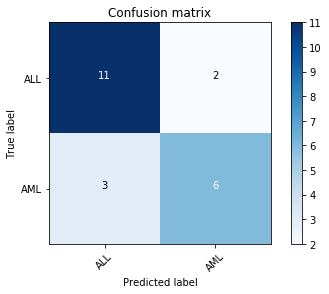

In [7]:
# ***Evaluation with different models****
# Using standard ML algorithms on the training set. 
# Evaluate with the test set using basic_metric() function above for basic
# accuracy and precision score for each class as initial evaluation.

# ***kNN k=1*** Using k nearest neighbors from sci-kit learn 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
p_1nn = knn.predict(X_test)
print("Metrics for kNN, k = 1:")
basic_metrics(p_1nn, y_test)

Metrics for kNN, k = 3:
Accuracy:0.73
Precision ALL: 0.68
Precision AML: 1.00 

Confusion matrix, without normalization
[[13  0]
 [ 6  3]]


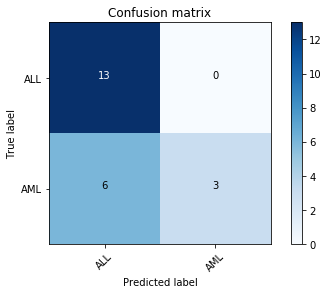

In [8]:
# ***kNN k=3*** Using k nearest neighbors from sci-kit learn 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
p_3nn = knn.predict(X_test)
print("Metrics for kNN, k = 3:")
basic_metrics(p_3nn, y_test)

Metrics for SVM: 
Accuracy:0.82
Precision ALL: 0.91
Precision AML: 0.73 

Confusion matrix, without normalization
[[10  3]
 [ 1  8]]


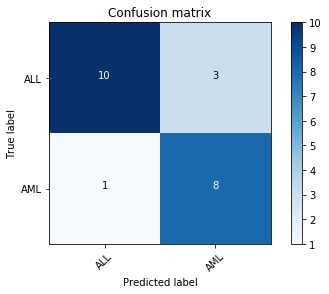

In [9]:
# ***SVM*** 
svm = LinearSVC()
svm.fit(X_train, y_train)
p_svm = svm.predict(X_test)
print("Metrics for SVM: ")
basic_metrics(p_svm, y_test)

In [10]:
# ***Random Forest***
# check to see what is best estimator
rf_param = {
    "n_estimators": [1,10,50,100,500,1000],
    "criterion": ["gini","entropy"],
    "max_features": ["auto"],
    "max_depth": [None,1,5,10],
    "max_leaf_nodes": [None],
    "oob_score": [False],
    "n_jobs": [-1],
    "warm_start": [False],
    "random_state": [1]
}
rf_model_r = RandomForestClassifier()
rf_r = GridSearchCV(estimator=rf_model_r, param_grid=rf_param, 
                              scoring=None,
                              n_jobs=-1, 
                              cv=10, 
                              verbose=1,
                              return_train_score=True)

rf_r.fit(X_train, y_train)

print("Best score:", rf_r.best_score_)
print(rf_r.best_estimator_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.1min finished


Best score: 0.72
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)


Metrics for Random Forest: 
Accuracy:0.59
Precision ALL: 0.59
Precision AML: 0.00 

Confusion matrix, without normalization
[[13  0]
 [ 9  0]]


/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


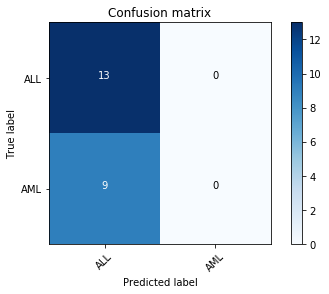

In [11]:
# Use best estimator for model prediction and metrics
rf_model = rf_r.best_estimator_
y_pred_rf = rf_model.predict(X_test)
print("Metrics for Random Forest: ")
basic_metrics(y_pred_rf, y_test)